In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from utils import *

In [2]:
N = 1000
all_data = []
for i in range(N):
    r1 = np.random.rand(1)
    r2 = np.random.rand(1)
    if np.sin(4*r1) < r2:
        label = 0
    # if r1 ** 2 < r2:
    #     label = 0
    else:
        label = 1
    all_data.append([torch.tensor([r1, r2]), label])

C:\Users\szilv\AppData\Local\Temp\ipykernel_16500\1065586.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  all_data.append([torch.tensor([r1, r2]), label])


c:\Users\szilv\OneDrive\Dokumentumok\summer_2022\summer_venv\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\szilv\OneDrive\Dokumentumok\summer_2022\summer_venv\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


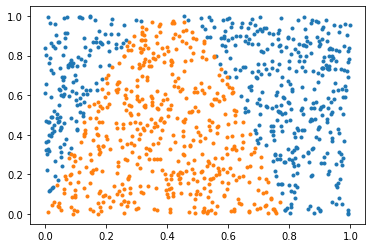

In [3]:
zeros_x = [all_data[i][0][0] for i in range(N) if not all_data[i][1]]
zeros_y = [all_data[i][0][1] for i in range(N) if not all_data[i][1]]

ones_x = [all_data[i][0][0] for i in range(N) if all_data[i][1]]
ones_y = [all_data[i][0][1] for i in range(N) if all_data[i][1]]

plt.plot(zeros_x, zeros_y, '.')
plt.plot(ones_x, ones_y, '.')

In [4]:
train_data = all_data[:N*8//10]
test_data = all_data[N*8//10:]
batch_size = 20
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [5]:
output1 = 10

model = nn.Sequential(
    nn.Linear(2, output1),
    nn.ReLU(),
    nn.Linear(output1, 1)
)

In [22]:
from tqdm.notebook import tqdm, trange

epochs = 200
num_of_params = get_n_params(model)


optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

effective_ranks = []

for epoch in trange(epochs):
    row_counter = 0
    tensor = torch.zeros((len(train_loader),num_of_params))
    C_matrices = []
    for points, labels in train_loader:
        
        optimizer.zero_grad()

        x = points[:,:,0].float()
        # print(x.shape)
        labels = labels[:,None].double()

        y = model(x)
        loss = criterion(y, labels)
        
        loss.backward()
        optimizer.step()

        tensor[row_counter, :] = flatten_and_together([param.grad for param in list(model.parameters())])
        row_counter += 1
    C_matrix = tensor @ tensor.T
    C_diags = np.sqrt(np.outer(tensor.diagonal(), tensor.diagonal()))
    effective_ranks.append(effective_rank(tensor))
    C_matrices.append(C_matrix / C_diags)
    

  0%|          | 0/200 [00:00<?, ?it/s]

tensor([ 0.0976, -0.0689,  0.0000,  0.0000,  0.0156, -0.0159, -0.0081, -0.0034,
         0.0000,  0.0000, -0.0266, -0.0051,  0.0457, -0.0624, -0.0142,  0.0369,
        -0.0728, -0.0390, -0.0045, -0.0233, -0.0160,  0.0000,  0.0086,  0.0393,
         0.0000,  0.1481, -0.2392,  0.0008, -0.0422, -0.0540, -0.0135,  0.0000,
        -0.0088, -0.0528,  0.0000,  0.0776,  0.0221, -0.0148,  0.0091,  0.0104])
tensor([ 6.0343e-02, -2.2709e-02,  0.0000e+00,  0.0000e+00,  1.5069e-02,
         5.6526e-02, -5.3207e-03,  2.3109e-02,  0.0000e+00,  0.0000e+00,
         2.6825e-02, -9.1635e-02,  2.8130e-02, -7.8924e-02,  1.5222e-03,
        -9.0290e-03, -6.8637e-02,  1.7664e-01, -1.4177e-03,  1.3400e-02,
        -1.5255e-01,  0.0000e+00,  8.4425e-02, -5.2509e-02,  0.0000e+00,
        -6.5521e-02,  2.0587e-01, -4.8699e-02, -1.4769e-02, -6.0194e-03,
        -1.3345e-02,  0.0000e+00,  1.8236e-02, -1.9540e-02,  0.0000e+00,
         3.6306e-02, -1.8690e-02,  1.0070e-02,  1.4502e-02,  9.6159e-05])
tensor([ 0.062

C:\Users\szilv\AppData\Local\Temp\ipykernel_16500\1190026010.py:34: RuntimeWarning: invalid value encountered in sqrt
  C_diags = np.sqrt(np.outer(tensor.diagonal(), tensor.diagonal()))
C:\Users\szilv\AppData\Local\Temp\ipykernel_16500\1190026010.py:36: RuntimeWarning: divide by zero encountered in divide
  C_matrices.append(C_matrix / C_diags)


tensor([ 0.0006,  0.1001,  0.0000,  0.0000,  0.0202, -0.0268,  0.0115, -0.0225,
         0.0000,  0.0000, -0.1230,  0.0022,  0.0068,  0.0159, -0.0122,  0.0039,
         0.0547, -0.0291,  0.0379,  0.0215, -0.0998,  0.0000,  0.0477,  0.0389,
         0.0000, -0.0776,  0.0574,  0.0230, -0.0352, -0.1173,  0.0438,  0.0000,
        -0.0048,  0.0471,  0.0000, -0.1055, -0.0154,  0.0147, -0.0003,  0.0102])
tensor([ 0.0977,  0.0915,  0.0000,  0.0000,  0.0097,  0.0061, -0.0280,  0.0820,
         0.0000,  0.0000,  0.0435,  0.0653, -0.0029,  0.0502,  0.0029, -0.0019,
        -0.0823, -0.0835,  0.0298, -0.0204, -0.1681,  0.0000,  0.0197, -0.0013,
         0.0000,  0.0451, -0.1157,  0.0371,  0.1526,  0.0231,  0.0056,  0.0000,
         0.0010, -0.0537,  0.0000, -0.0308, -0.0057, -0.0089,  0.0025, -0.0057])
tensor([ 0.0326,  0.0026,  0.0000,  0.0000,  0.0001,  0.0248, -0.0264,  0.0343,
         0.0000,  0.0000,  0.0109, -0.0365,  0.0350,  0.0426,  0.0028,  0.0228,
        -0.0418, -0.0998,  0.0204, -0.

In [21]:
C_matrices[-1]

tensor([[ 24.1494,      nan,      inf,  ...,      nan, -11.0134,  -1.2779],
        [     nan,  22.7403,      inf,  ...,   6.1665,      nan,      nan],
        [     inf,      inf,      inf,  ...,     -inf,     -inf,     -inf],
        ...,
        [     nan,   6.1665,     -inf,  ...,   8.4152,      nan,      nan],
        [-11.0134,      nan,     -inf,  ...,      nan,  15.9747,   2.7847],
        [ -1.2779,      nan,     -inf,  ...,      nan,   2.7847,   1.6511]])

Text(0, 0.5, 'Effective rank')

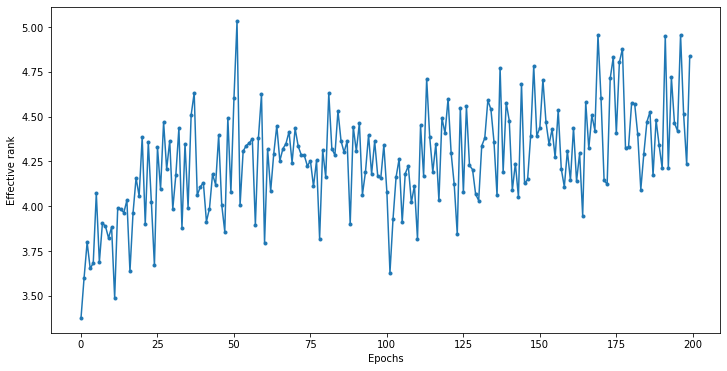

In [28]:
from matplotlib.pyplot import figure

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(6)

plt.plot(effective_ranks, '.-')
plt.xlabel("Epochs")
plt.ylabel("Effective rank")


In [29]:
correct_test = 0
with torch.no_grad():
        # Iterate through test set minibatchs 
        for numbers2, labels2 in test_loader:
            numbers2 = numbers2
            labels2 = labels2.double()[:,None]
            # Forward pass
            x2 = numbers2[:,:,0].float()
            y2 = model(x2)
            predictions2 = ((y2>0)*1)
            # print(predictions2)
            # print(labels2)
            correct_test += torch.sum((predictions2 == labels2).float())
            # print(correct_test)
print(f'Test accuracy: {correct_test/len(test_data)}')


Test accuracy: 0.7799999713897705


In [15]:
tensor = torch.tensor([[-7.9811e-01,  4.2888e-01],[ 1,  0.0000e+00]])
effective_rank(tensor)

tensor(1.6498)

In [16]:
tensor = torch.tensor([1/2, 3/4])
model(tensor)

tensor([3.2733], grad_fn=<AddBackward0>)